In [2]:
from glob import glob
import os
import mne
from mne.preprocessing import annotate_muscle_zscore
from IPython.display import display, HTML
from pathlib import Path  

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import torch
import seaborn as sns
sns.set_theme()
mne.set_log_level("critical")


asd_file_path=sorted(glob('data/asd/*.set'))
td_file_path=sorted(glob('data/td/*.set'))

asd_files = [i for i in asd_file_path]
td_files = [i for i in td_file_path]

In [5]:
# Find bad spans of data using mne.preprocessing.annotate_muscle_zscore
def markMuscleArtifacts(raw, threshold, plot=False):
    #print("markMuscleArtifacts")
    threshold_muscle = threshold  # z-score
    annot_muscle, scores_muscle = annotate_muscle_zscore(
    raw, ch_type="eeg", threshold=threshold_muscle, min_length_good=0.2,
    filter_freq=[0, 60])
    raw.set_annotations(annot_muscle)

# Drop epochs marked as bad
def dropBadEpochs(epochs, plotLog=False):
    reject_criteria = dict(eeg=150e-6) # 150 µV
    flat_criteria = dict(eeg=1e-6) # 1 µV
    epochs.drop_bad(reject=reject_criteria, flat=flat_criteria)
    if plotLog: epochs.plot_drop_log()

# Get raw data and return filtered version
def get_filtered_data(file_path, l_freq = 0.5, h_freq = 40, muscle_thresh = 5):
    #print("loading", file_path)

    # Load raw data fronm file
    raw = mne.io.read_raw_eeglab(file_path,preload=True)

    raw.set_eeg_reference()

    # Mark bad data
    markMuscleArtifacts(raw, muscle_thresh)
  
    # Create even length epochs
    epochs = mne.make_fixed_length_epochs(raw,duration=1,overlap=0, preload=True)

    # Drop Bad Epochs
    dropBadEpochs(epochs, False)

    #print(epochs)

    # Apply filter
    filtered = epochs.copy().filter(l_freq=l_freq, h_freq=h_freq)

    return filtered

def checkLeftNumbers(channel):
  return (("1" in channel) or ("3" in channel) or ("5" in channel) or ("7" in channel) or ("9" in channel)) and ("10" not in channel)

def checkRightNumbers(channel):
    return ("2" in channel) or ("4" in channel) or ("6" in channel) or ("8" in channel) or ("10" in channel)

def getFrontalChannels(raw):
  _channels = [i for i in raw.ch_names if "F" in i and "C" not in i]
  return raw.copy().pick_channels(_channels)

def getCentralChannels(raw):
  _channels = [i for i in raw.ch_names if "C" in i and "F" not in i]
  return raw.copy().pick_channels(_channels)

def getPosteriorChannels(raw):
  _channels = [i for i in raw.ch_names if ("P" in i or "O" in i) and "C" not in i]
  return raw.copy().pick_channels(_channels) 

def getLeftChannels(raw):
  _channels = [i for i in raw.ch_names if checkLeftNumbers(i)]
  return raw.copy().pick_channels(_channels) 

def getRightChannels(raw):
  _channels = [i for i in raw.ch_names if checkRightNumbers(i)]
  return raw.copy().pick_channels(_channels)

def getPSD(epochs, fmax = 40):
   return epochs.compute_psd(fmax=fmax)

def split(file):
  raw = get_filtered_data(file)
  frontal = getFrontalChannels(raw)
  central = getCentralChannels(raw)
  posterior = getPosteriorChannels(raw)
  left = getLeftChannels(raw)
  right = getRightChannels(raw)
  return [ frontal, central,  posterior,  left, right, raw]

|Features|Post|Front|Left|Right|PR |PF |LR |ALL |
|--------|----|-----|----|-----|---|---|---|----|
| Delta  |52% |53%  |47% |55%  |55%|52%|57%|51% |
| Alpha  |48% |34%  |35% |44%  |47%|53%|53%|36% |
| Beta   |47% |43%  |40% |49%  |47%|51%|57%|42% |
| Theta  |50% |49%  |44% |52%  |50%|49%|58%|48% |
|Theta-Beta|49% |47%|40% |51%  |47%|51%|58%|45% |
|Theta-Delta|51%|51%|47% |55%  |53%|52%|59%|51% |
|Theta-Delta-Alpha| |    |     |   |51%|57%|    |


|Features|PF |LR |
|--------|---|---|
| Delta  |52%|57%|
| Alpha  |53%|53%|
| Beta   |51%|57%|
| Theta  |49%|58%|
|Theta-Beta  |51%|58%|
|Theta-Delta |52%|59%|
|Theta-Alpha |54%|58%|
|Theta-Delta-Alpha|51%|57%|
|Theta-Delta-Alpha-Beta|50%|57%|
|Delta-Beta|50% |58% |  
|Delta-Alpha|52%|58% |
|Beta-Alpha |50%|56% |

In [331]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold,GridSearchCV,cross_val_score,cross_validate 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVR, SVR
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB, MultinomialNB


# ML Approach
debug_asd_file_path=sorted(glob('data/asd/*.set'))
debug_td_file_path=sorted(glob('data/td/*.set'))

# https://mne.discourse.group/t/psd-multitaper-output-conversion-to-db-welch/4445
def scaleEEGPower(powerArray):
    powerArray = powerArray * 1e6**2 
    powerArray = (10 * np.log10(powerArray))
    return powerArray

# Returns and array containing band power features for each epoch. Results are averaged across all channels
def extractFetures(psd):
    #print(psd.shape)
    features = []
    for epoch in psd:
        #print(epoch.shape),
        alpha = np.mean(scaleEEGPower(epoch[:, 8:12]), axis=(1,0)) #get mean alpha value for this epoch across all channels
        delta = np.mean(scaleEEGPower(epoch[:, 0:4]), axis=(1,0))
        theta = np.mean(scaleEEGPower(epoch[:, 4:8]), axis=(1,0))
        beta = np.mean(scaleEEGPower(epoch[:, 12:30]), axis=(1,0))
        features.append([theta, delta, beta, alpha])
        #print(features)
    return features
    
def handlePSD(raw):
    psd = getPSD(raw)
    psd_np = psd.get_data() 
    features = extractFetures(psd_np)
    return features

def getAllPSDFeatures(file):
    raw = get_filtered_data(file)
    return handlePSD(raw)

def getFrontalPSDFeatures(file):
    filtered_data = get_filtered_data(file)
    channels_raw = getFrontalChannels(filtered_data)
    return handlePSD(channels_raw)

def getPosteriorPSDFeatures(file):
    filtered_data = get_filtered_data(file)
    channels_raw = getPosteriorChannels(filtered_data)
    return handlePSD(channels_raw)

def getLeftPSDFeatures(file):
    filtered_data = get_filtered_data(file)
    channels_raw = getLeftChannels(filtered_data)
    return handlePSD(channels_raw)

def getRightPSDFeatures(file):
    filtered_data = get_filtered_data(file)
    channels_raw = getRightChannels(filtered_data)
    return handlePSD(channels_raw)

def getFeatures(file, regionExtractors):
    print(file)
    featureList = []
    for extractor in regionExtractors:
        featureList.append(extractor(file))
    return np.hstack(featureList)
    #print(len(featureList))
    #print(featureList)
    #print(o)
    #print(o.shape)

def getFeatureLabels(extractor, regionExtractors, control_file_path, experiment_file_path, save=False):
    control_epochs = [extractor(subject, regionExtractors) for subject in control_file_path] # subject, epochs, features(2) 
    experiment_epochs = [extractor(subject, regionExtractors) for subject in experiment_file_path] # subject, epochs, features(2)
    control_epochs_labels = [len(i) * [0] for i in control_epochs]
    experiment_epochs_labels = [len(i) * [1] for i in experiment_epochs ]
    data_list = control_epochs + experiment_epochs
    label_list = control_epochs_labels + experiment_epochs_labels
    groups_list = [[i]*len(j) for i, j in enumerate(data_list)]
    data_array = np.vstack(data_list)
    label_array = np.hstack(label_list)
    group_array = np.hstack(groups_list)
    print(data_array.shape, label_array.shape,group_array.shape)
    if(save):
        # theta, delta, beta, alpha
        df = pd.DataFrame(data_array, columns = ['L_T', 'L_D', 'L_B', 'L_A', 'R_T', 'R_D', 'R_B', 'R_A', 'F_T', 'F_D', 'F_B', 'F_A', 'P_T', 'P_D', 'P_B', 'P_A'])
        df['class'] = label_array
        df['group'] = group_array
        print(df.shape)
        print(df)
        print(df['class'])
        df.to_csv('./data/dataframes/all_bands.csv', index=False)
        #print(updated_data.shape)
    return [data_array, label_array, group_array] 

def evalML(data_array, label_array, group_array, pipelineFunc=getBasicPipeline, splits=5, classifier=LogisticRegression()):     
    clf=classifier
    gkf=GroupKFold(n_splits=splits)
    #param_grid = {'classifier__C': [0.01, 0.05,0.1,0.5, 1,2,3,4,5,8, 10,12,15]}
    param_grid = {}
    pipe=pipelineFunc(clf)
    gscv=GridSearchCV(pipe, param_grid, cv=gkf, n_jobs=16)
    gscv.fit(data_array, label_array, groups=group_array)
    print("Training acc: ", gscv.best_score_)
    return gscv


#getFeatures(debug_td_file_path[0], [getFrontalPSDFeatures, getPosteriorPSDFeatures])

#evalLogisticRegressionML(data_array, label_array, group_array, 5)

'''
regions = [
    [getFrontalPSDFeatures], 
    [getRightPSDFeatures], 
    [getLeftPSDFeatures], 
    [getPosteriorPSDFeatures], 
    [getPosteriorPSDFeatures, getRightPSDFeatures],
    [getPosteriorPSDFeatures, getFrontalPSDFeatures],
    [getLeftPSDFeatures, getRightPSDFeatures],
    [getAllPSDFeatures]
]
'''


def main():
    #region_labels = ["F", "R", "L", "P", "PR", "PF", "LR", "ALL"]
    #region_labels = ["PR", "PF", "LR", "ALL"]

    '''
    regions = [
        [getPosteriorPSDFeatures, getFrontalPSDFeatures],
        [getLeftPSDFeatures, getRightPSDFeatures],
    ]
    '''

    regions = [
        [getLeftPSDFeatures, getRightPSDFeatures, getFrontalPSDFeatures, getPosteriorPSDFeatures],
    ]

    region_labels = ["LR"]
    for idx, region in enumerate(regions): 
        data_array, label_array, group_array = getFeatureLabels(getFeatures, region, debug_td_file_path, debug_asd_file_path, True)
        print("Region: ", region_labels[idx])
        #evalLogisticRegressionML(data_array, label_array, group_array, 2)


def getBasicPipeline(clf):
    return Pipeline([('scaler',StandardScaler()),('classifier',clf)])

def getPolynomialPipeline(clf):
    return Pipeline(
        [
            ('scaler', StandardScaler()),
            ('classifier', clf)
        ]
    )


def testClassifiers(classifiers, train_data, train_labels, groups, test_data, test_labels):
    for clf in classifiers:
        print(clf)
        model = evalML(train_data, train_labels, groups, pipelineFunc=getPolynomialPipeline, splits=5, classifier=clf)
        y_pred = model.predict(test_data)
        score = accuracy_score(test_labels, y_pred)
        print("test acc", score)

def test():
    df = pd.read_csv('./data/dataframes/all_bands.csv')
    #print(df.shape)
    patient_cutoff = 23
    control_cutoff = 51
    data_array_train = df[((df['class'] == 0) & (df['group'] < patient_cutoff)) | ((df['class'] == 1) & (df['group'] < control_cutoff))]
    data_array_test = df[((df['class'] == 0) & (df['group'] >= patient_cutoff)) | ((df['class'] == 1) & (df['group'] >= control_cutoff))]
    features = ['F_B', 'L_B', 'R_B', 'P_B']
    #print(data_array_test)
    df = data_array_train
    #data_array = df[['L_T', 'L_D', 'L_B', 'L_A', 'R_T', 'R_D', 'R_B', 'R_A']]
    data_array = df[features]
    label_array = df['class']
    group_array = df['group']
    #print(data_array.shape)
    #print(data_array, label_array, group_array)

    #test_data_array = data_array_test[['L_T', 'L_D', 'L_B', 'L_A', 'R_T', 'R_D', 'R_B', 'R_A']]
    test_data_array = data_array_test[features]
    test_label_array = data_array_test['class']
    test_group_array =  data_array_test['group']
    #print(test_group_array)
 
    # SVM
    # kernel : {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf
    _svm = SVC(C=1, kernel='linear')

    #Decision Trees
    _d_trees = DecisionTreeClassifier()

    #Ensmble
    _rf = RandomForestClassifier(n_estimators=500,  n_jobs=-1)
    _ada = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=20), n_estimators=500, algorithm="SAMME.R", learning_rate=0.5
    )
     
    #KNN
    _knn = KNeighborsClassifier(n_neighbors=4)

    #LDA
    _lda = LinearDiscriminantAnalysis(solver='svd')

    #Narive Bayes
    _gnb = GaussianNB()
    
    '''
    model = evalML(data_array, label_array, group_array, pipelineFunc=getPolynomialPipeline, splits=5, classifier=_gbr)
    print("test")
    y_pred = model.predict(test_data_array)
    score = accuracy_score(test_data_array, y_pred)
    print(score)
    '''

    classifiers = [_svm, _d_trees, _rf, _gnb, _ada, _knn, _lda, _gnb]
    #classifiers = [_svm]

    testClassifiers(classifiers, data_array, label_array, group_array, test_data_array, test_label_array)


#main()
test()


SVC(C=1, kernel='linear')
Training acc:  0.576458139997999
test acc 0.6046511627906976
DecisionTreeClassifier()
Training acc:  0.5484384731424453
test acc 0.5128518971848225
RandomForestClassifier(n_estimators=500, n_jobs=-1)
Training acc:  0.5542103623084075
test acc 0.49938800489596086
GaussianNB()
Training acc:  0.44535433209086445
test acc 0.5055079559363526
AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=20),
                   learning_rate=0.5, n_estimators=500)
Training acc:  0.5436392142444938
test acc 0.48959608323133413
KNeighborsClassifier(n_neighbors=4)
Training acc:  0.5294609102520222
test acc 0.4969400244798042
LinearDiscriminantAnalysis()
Training acc:  0.5330642452329359
test acc 0.605875152998776
GaussianNB()
Training acc:  0.44535433209086445
test acc 0.5055079559363526


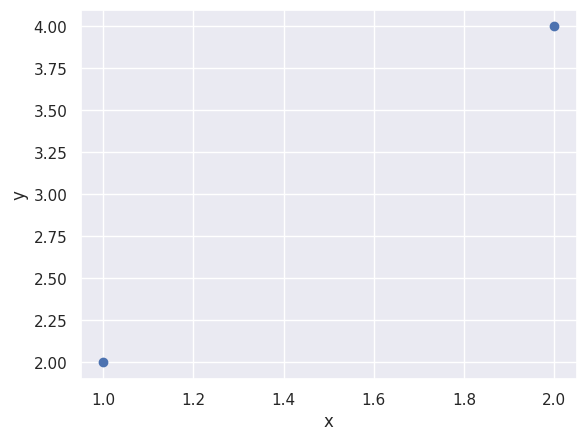

1.9999999999999996


In [243]:
# This may be usefor getting the 1/f exponent

import matplotlib.pyplot as plt

x = np.array([1, 2])
y = np.array([2, 4])

plt.plot(x, y, 'o')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

import numpy as np
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x.reshape(-1, 1), y)

slope = model.coef_[0]

print(slope)



In [ ]:
# Asymmetry


# (Page 10) Li Q, Weiland R F, Konvalinka I, Mansvelder H D, Andersen T S, Smit D J A, Begeer S and Linkenkaer-Hansen K 2022 Intellectually able adults with autism spectrum disorder show typical resting-state EEG activity Sci Rep-uk 12 19016
EEG power asymmetry was calculated by subtracting each left hemispheric patch from the corresponding 
patch in the right hemisphere 77, followed by averaging across the brain regions.

# EEGLAB Listserv:
> Hi all. In order to compute EEG asymmetry on resting state datasets I use
> the EEGlab toolbox spectopo function, so I get the spectra in dB for each
> frequency, then I calculate absolute power (with the formula
> 10^10(spetra)/10) and a mean of this absolute power for each electrode in
> the alpha band. I then calculate asymmetry log(absolute power
> F4)-log(absolute power F3) to calculate the index, or even using a mean of
> absolute power for groups of electrodes. Do you think that is the right?
> Does the calculation of asymmetry index requires the use of absolute power?



In [ ]:
# Connectivity

# https://mne.tools/mne-connectivity/stable/generated/mne_connectivity.spectral_connectivity_epochs.html#mne_connectivity.spectral_connectivity_epochs
# https://mne.tools/mne-connectivity/stable/auto_examples/dpli_wpli_pli.html#sphx-glr-auto-examples-dpli-wpli-pli-py


In [ ]:
# Prepare Data Frame for plotting PSD

df = pd.DataFrame({})
regions_id = ["frontal", "central", "posterior", "left", "right"]

groups = [{"data": asd_files, "group_id": "ASD"}, {"data": td_files, "group_id": "TD"}]

# Find a better way to format this at some point. Nested loops are very slow
# Prepare data frame to plot PSD comparison
for type_id, group in enumerate(groups):
    for subject_id, subject in enumerate(group['data']):
        print(subject_id/len(group['data']))
        frontal, central, posterior, left, right, all = split(subject)
        regions = [frontal, central, posterior, left, right]
        for id_region, region in enumerate(regions):
            psd = getPSD(region)
            psd_np = psd.get_data()
            _psd = np.mean(psd_np, axis=(0))
            for id_channel, channel in enumerate(_psd):
                for id_freq, sample in enumerate(channel):
                    # Data type, Subject ID, Brain Region, Channel Name, Freq Bin, Sample
                    #print(data_type, subject_id, brain_region, frontal.ch_names[idx], idj, sample)
                    new_row = pd.DataFrame.from_records([{
                        "Type":group["group_id"],  
                        "Subject": subject_id,
                        "Region": regions_id[id_region],
                        "Channel": region.ch_names[id_channel],
                        "Freq": id_freq,
                        "Sample": sample
                    }])
                    df = pd.concat([df, new_row])
                    
filepath = Path('data/asd_td_3.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(filepath, index=False) 

In [ ]:
# Selecting subset example (PANDAS)

# https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html
#df = pd.read_csv(filepath) 
#display(df)
#df = df[(df["Freq"] < 12) & (df["Freq"] > 8)]display(df)


# Type, Subject, Region, Channel, Band, Value
#sns.lineplot(data=df, x="Freq", y="Sample", hue="Type")
#plt.show()

In [ ]:
# MISC

# Creating Feature Structure


def getTotalSubjects(groups):
    subject_count = 0
    for i in groups:
        subject_count += len(i["data"])
    return subject_count

def extractFetures(signal):
    delta = np.mean(signal[:4])
    theta = np.mean(signal[4:8])
    alpha = np.mean(signal[8:12])
    beta = np.mean(signal[13:30])
    gamma = np.mean(signal[30:40])
    return [gamma]

def extractRegionFeatures(epoch, ranges=[[1,4], [8,12]]):
    psd = getPSD(epoch)
    epochs_features = []
    psd_np = psd.get_data()

    for i in ranges:
        #print(i)
        band = scaleEEGPower(psd_np[:, :, i[0]:i[1]])
        band_channel_mean = np.mean(band, axis=(1, 2)) # average across channels
        #print(band_channel_mean)
        #print(band_channel_mean.shape)
        epochs_features.append(band_channel_mean)
        #alpha_reshape = alpha.reshape(95, -1)
        #print(alpha_reshape.shape)
        #print(alpha_reshape)
    return np.stack(epochs_features, axis=1)

regions_id = ["frontal", "central", "posterior", "left", "right"]
groups = [{"data": asd_files, "group_id": "ASD"}, {"data": td_files, "group_id": "TD"}]
frontal, central, posterior, left, right, all = split(groups[0]['data'][0])
featureCount = 2
regions = [frontal, central, posterior, left, right]
regionCount = len(regions)
epochs = len(frontal)
X_2d = np.empty([epochs, regionCount, featureCount], dtype=float)
print("X_2d", X_2d.shape)



def main():
    x = []
    for region_id, region_epoch in enumerate(regions):
        x.append(extractRegionFeatures(region_epoch))
    t = np.stack(x, axis=1)
    print(t.shape)
    print(t)

main()


# Misc

print(len(asd_files))
print(len(td_files))

def channel_in_file(channel, file_path):
    #print("loading", file_path)
    datax=mne.io.read_raw_eeglab(file_path,preload=True)
    return channel in datax.ch_names

def checkChannels(channels, file_path):
  results = []
  for idx, channel in enumerate(channels):
    results.append(0)
    for file in file_path: 
      print(file)
      results[idx] += channel_in_file(channel, file)
      print(results)


#ASD
#channels = np.array(['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2'])
#channel_count = np.array([27, 27, 26, 25, 25, 24, 27, 24, 26, 23, 26, 23, 26, 26, 18, 23, 23, 25, 25, 27, 25, 26, 23, 27, 26, 26, 27, 24, 25, 27, 26, 25, 26, 27, 25, 24, 24, 26, 26, 22, 24, 25, 22, 21, 24, 24, 25, 23, 24, 22, 20, 23, 26, 26, 24, 27, 24, 24, 26, 27, 25, 25, 27])
#greater_25 = ['Fp1', 'AF7', 'AF3', 'F7', 'FC5', 'FC1', 'C3', 'C5', 'P1', 'P5', 'P9', 'PO7', 'PO3', 'O1', 'POz', 'Pz', 'Fpz', 'Fp2', 'Fz', 'F2', 'CP6', 'CP4', 'P2', 'P8', 'P10', 'O2']
#output = channels[channel_count > 25]
#print(output)
#checkChannels(channels, asd_file_path)

def read_data(file_path):
    pass
    #print("loading", file_path)
    #raw = mne.io.read_raw_eeglab(file_path,preload=True)
    #return raw
    #epochs=mne.make_fixed_length_epochs(datax,duration=1,overlap=0, preload=True)
    #print("original ", epochs.ch_names)
    #epochs.pick_channels(['Fp1', 'Fpz', 'Fp2', 'O1', 'Oz', 'O2', 'Fz', 'FCz'])

    '''
    datax.set_eeg_reference()
    datax.filter(l_freq=1,h_freq=45)
    epochs=mne.make_fixed_length_epochs(datax,duration=1,overlap=0)
    epochs_np=epochs.get_data()
    return epochs, epochs_np #trials,channel,length
    '''

